# Code written by:

## Amulya Chetlapalli (achetlapalli@umass.edu)
## Sakshi Bhalerao (sbhalerao@umass.edu)
## Muskan Jain (muskanjain@umass.edu)


In [1]:
#installations

!pip install psycopg2
!pip install scipy
!pip install sklearn
!pip install sqlalchemy 
!pip install seaborn
!pip install matplotlib


In [2]:
import pandas as pd
import collections
from math import log2
from scipy.special import rel_entr
from scipy import stats as kl
from decimal import Decimal
from sklearn import preprocessing
from math import log,ceil
import time
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
functions = ['count', 'sum', 'avg', 'min','max']
attributes = ['workclass','education','occupation','relationship','race','sex','native-country','income']
measures = ['age', 'education-num','capital-gain','capital-loss','hours-per-week']


k=5 
partitions=5
delta= 0.01

In [4]:
import psycopg2

#Connecting with the postgresql server
#con = psycopg2.connect(database="cs645-project", user="postgres", password="muskan", host="127.0.0.1", port="5432")
con = psycopg2.connect(database="cs645-project", user="postgres", password="Amulya123$", host="127.0.0.1", port="5432")

print("Database connected successfully")


Database connected successfully


In [5]:
#executing query on postgresql 
def execute_query(query):
    cur = con.cursor()
    cur.execute(query)
    return cur

#fetching results from the connection F
def get_query_results(cur):
    if isinstance(cur,dict):
        return cur.items()
    else:
        return cur.fetchall()

#converting into an array of float values
def convert_float(vals):
    return [float(x) for x in vals]

#calculating utility value
def get_utility_value(p,q):
    p = convert_float(p)
    q = convert_float(q)
    return kl.entropy(p,q)

def dataset_vals(dataset):
    table, condition_ref, condition_tar = None, None, None
    if dataset == "census":       
        table = "Adult"
        condition_ref = '"marital-status" = \'Unmarried\' '
        condition_tar = '"marital-status" = \'Married\' '
    elif dataset == "dblp":   
        table = "dblp"
        condition_ref = "\"venue_year\" <= 1976"
        condition_tar = "\"venue_year\" > 1976"
    return (table, condition_tar, condition_ref)

#creating each visualization
def top_k_data(view, dataset):
    a,m,f = view
    query_vals = dataset_vals(dataset)
    tar_query ='select "'+a+'", '+f+'("'+m+'") from public."'+ str(query_vals[0]) +'" where ' + query_vals[1] +' and "' + a +'" is not null group by "'+a+'" order by "'+a+'" ;'
    ref_query ='select "'+a+'", '+f+'("'+m+'") from public."'+ str(query_vals[0]) +'" where ' + query_vals[2] +' and "' + a + '"  is not null group by "'+a+'" order by "'+a+'" ;'
    
    tar_res = execute_query(tar_query)
    ref_res = execute_query(ref_query)
    tar_res = pd.DataFrame(tar_res.fetchall(), columns=["category","value_tar"])
    ref_res = pd.DataFrame(ref_res.fetchall(), columns=["category","value_ref"])

    merged = pd.merge(tar_res,ref_res,on='category',how='outer')

    merged['value_tar'] = merged['value_tar'].fillna(0)
    merged['value_ref'] = merged['value_ref'].fillna(0)
   
    merged["difference"] = merged["value_tar"] - merged ["value_ref"]
    merged['difference'] = merged['difference'].abs()
    
    
    if query_vals[0] =="Adult":
        Labels = "Marrital-Status"
        cat1 = "Married"
        cat2 = "Unmarried"
        merged = merged.iloc[:, 0:3]
    else:
        Labels = "Published Year"
        cat1 = ">1976"
        cat2 = "<=1976"
        merged = merged.iloc[0:20, 0:3]
 
    merged_viz_data = pd.DataFrame(columns=['{}'.format(a), Labels, '{}({})'.format(f.upper(),m)])
    
    for category, v1, v2 in merged.values:
        merged_viz_data.loc[len(merged_viz_data)] = [category, cat1, int(v1)]
        merged_viz_data.loc[len(merged_viz_data)] = [category, cat2, int(v2)]
    
    sb_plot = sb.catplot(x=a, y='{}({})'.format(f.upper(),m), hue=Labels, data=merged_viz_data, kind='bar', height=8, aspect=2)
    sb_plot.set_xticklabels(rotation=45)
    
#displaying all visualizations present top_k_utilities
def get_visualizations(top_k_utilities, dataset):
    for v in top_k_utilities:
        print(v)
        top_k_data(v, dataset)

# Exhaustive Search

In [6]:
#normalizing all function-measure values in each view
def normalize(res):
    total = float(sum(res))
    if total==0:
        return res
    norm = [float(i)/(total) for i in res]
    return norm

#converting the query outputs for both reference and target views to list of lists
def query_to_list(ref_res,tar_res):
    ref_vals = []
    tar_vals = []
    all_keys = set()
    const = Decimal(1e-10)
    vals = collections.defaultdict(list)
    ref_keys = dict()
    tar_keys = dict()
    
    #fetching and storing all tuples belonging to reference view and storing them against key(distinct attribute values)
    for key,val in get_query_results(ref_res):
        all_keys.add(key)
        if val!=0:
            ref_keys[key] = val
        else:
            ref_keys[key] = const

    #fetching and storing all tuples belonging to target view and storing them against key(distinct attribute values)
    for key,val in get_query_results(tar_res):
        all_keys.add(key)
        if val!=0:
            tar_keys[key] = val
        else:
            tar_keys[key] = const
        
    #converting the above key-value dictionaries to lists
    for key in all_keys:
        if key in ref_keys:
            ref_vals.append(ref_keys[key])
        else:
            ref_vals.append(const)
        if key in tar_keys:
            tar_vals.append(tar_keys[key])
        else:
            tar_vals.append(const)
    return ref_vals, tar_vals

#generating normalized view values for a certain a,f,m value present in variable "view"
def generate_views(view, dataset):
    #writing a,f,m in the form of a query
    query_vals = dataset_vals(dataset)
    reference_query = 'Select "' + view[1] +'", '+ view[0] + '("' + view[2] + '") from public."'+ str(query_vals[0]) +'" where ' + query_vals[2] +' and "' + view[1] + '" is not null group by "' + view[1] + '" order by "' + view[1] + '";'
    target_query = 'Select "' + view[1] +'", '+ view[0] + '("' + view[2] + '") from public."'+ str(query_vals[0]) +'" where ' + query_vals[1] +' and "'+ view[1] + '" is not null group by "' + view[1] + '" order by "' + view[1] + '";'
    
    #executing queries
    ref_res = execute_query(reference_query)
    tar_res = execute_query(target_query)
    
    #converting both queries to lists form and normalizing them
    ref_res,tar_res = query_to_list(ref_res,tar_res)
    ref_res,tar_res = normalize(ref_res), normalize(tar_res)
    return ref_res, tar_res
    
def get_top_k_views(utility_values):
    temp = sorted(utility_values,key = lambda x: x[0])[::-1]
    return temp[:k]

In [7]:
#performing exhaustive search
def exhaustive_search(dataset):
    all_views = []
    utility_values = []

    #generating all possible f,a,m combinations 
    for f in functions:
        for a in attributes:
            for m in measures:
                all_views.append((f,a,m))
    
    #analyzing every view individually
    for view in all_views:
        r_dist, t_dist = generate_views(view, dataset)
        utility_values.append((get_utility_value(r_dist, t_dist),view))

    top_k_utilities = get_top_k_views(utility_values)
    
    return top_k_utilities


In [8]:
start1 = time.perf_counter()
DATA = "census"
top_k_utilities = exhaustive_search(DATA)
end1 = time.perf_counter()

print("Exhaustive Search :")
print("TOP K Views: utlity_values + (a,f,m) :")
print(top_k_utilities)

Exhaustive Search :
TOP K Views: utlity_values + (a,f,m) :
[(21.424258347244706, ('avg', 'native-country', 'capital-loss')), (7.161588607350556, ('avg', 'native-country', 'capital-gain')), (6.297712854063942, ('max', 'native-country', 'capital-gain')), (6.128681220509516, ('max', 'native-country', 'capital-loss')), (4.338302874989178, ('sum', 'relationship', 'capital-gain'))]


# Shared-based Optimization

In [9]:
#converting the aggregated query outputs for both reference and target views to list of lists
def agg_queries_to_list(ref_res,tar_res):
    ref_vals = []
    tar_vals = []
    all_keys = set()
    const = Decimal(1e-10)
    vals = collections.defaultdict(list)
    ref_keys = dict()
    tar_keys = dict()
    ref_flag = False
    tar_flag = False
    
    #fetching and storing all tuples belonging to reference view and storing them against key(distinct attribute values)
    for items in get_query_results(ref_res):
        key = items[0]
        n = len(items) - 1
        all_keys.add(key)
        ref_keys[key] = list(items[1:])
    
    #fetching and storing all tuples belonging to target view and storing them against key(distinct attribute values)
    for items in get_query_results(tar_res):
        key = items[0]
        n = len(items) - 1
        all_keys.add(key)
        tar_keys[key] = list(items[1:])
        
    #converting the above key-value dictionaries to lists
    for key in all_keys:
        if key in ref_keys:
            ref_vals.append(ref_keys[key])
        else:
            ref_vals.append([const]*n)
        if key in tar_keys:
            tar_vals.append(tar_keys[key])
        else:
            tar_vals.append([const]*n)
            
    return ref_vals, tar_vals

#normalizing all function-measure values in each view for multi-attributes aggregate results
def agg_normalize(a,res):
    const = Decimal(1e-10)
    total = [0] * len(res[0])
    
    for j in range(len(res[0])):
        for i in range(len(res)):
            if res[i][j] == 0:
                res[i][j] = const
            
            total[j] += res[i][j]
            
    norm = [[0 for i in range(len(res))]for j in range(len(res[0]))]
    
    for j in range(len(res[0])):
        for i in range(len(res)):
            if total[j] == 0:
                norm[j][i] = res[i][j]
            else:
                norm[j][i] = float(res[i][j])/float(total[j])
    return norm

def get_agg_utility_value(a, ref, tar):
    i = 0
    utilities = []
    for f in functions:
        for m in measures:
            if a!=m:
                utilities.append((get_utility_value(ref[i],tar[i]),(a,f,m)))
                i += 1
    return utilities



In [10]:
#generating queries for multiple-attributes aggregation optimization 
def get_multi_agg_queries(dataset):
    queries = []
    query_vals = dataset_vals(dataset)
    for a in attributes:
        query = 'SELECT "'+a+'"'
        for f in functions:
            for m in measures:
                if a==m:
                    continue
                query += ', '+f+'("'+m+'")'
        married_query = query + ' from public."'+ str(query_vals[0]) +'" where ' + query_vals[1] +' and "' +a+ '" is not null group by "'+a+'" order by "'+a+'";'
        unmarried_query = query + '  from public."'+ str(query_vals[0]) +'" where ' + query_vals[2] +' and "' + a + '" is not null group by "'+a+'" order by "'+a+'";'
        queries.append([a,unmarried_query,married_query])
    return queries
        
#implementing shared-based optimization
def shared_based_optimization(dataset):
    #generating and calculating utility values for views corresponding to each attribute 'a'
    queries = get_multi_agg_queries(dataset)
    utility_values = []
    
    for a,reference_query,target_query in queries: 
        ref_res = execute_query(reference_query)
        tar_res = execute_query(target_query)
      
        ref_res,tar_res = agg_queries_to_list(ref_res,tar_res)
        ref_res,tar_res = agg_normalize(a,ref_res), agg_normalize(a,tar_res)
        utility_values.extend(get_agg_utility_value(a, ref_res, tar_res))
        
    top_k_utilities = get_top_k_views(utility_values)
    return top_k_utilities



In [11]:
start2 = time.perf_counter()
DATA = 'census'
top_k_utilities = shared_based_optimization(DATA)
end2 = time.perf_counter()

print("SHARED BASED OPTIMIZATION :")
print("TOP K Views: utlity_values + (a,f,m) :")
print(top_k_utilities)

SHARED BASED OPTIMIZATION :
TOP K Views: utlity_values + (a,f,m) :
[(21.424258347244706, ('native-country', 'avg', 'capital-loss')), (7.161588607350556, ('native-country', 'avg', 'capital-gain')), (6.297712854063942, ('native-country', 'max', 'capital-gain')), (6.128681220509516, ('native-country', 'max', 'capital-loss')), (4.338302874989178, ('relationship', 'sum', 'capital-gain'))]


# Pruning-based optimization

In [12]:
n = 32560
partitions = 5
bucket_len = ceil(n/partitions)


utility_details = collections.defaultdict(list)
utility_stats = collections.defaultdict(list)

for a in attributes:
    for f in functions:
        for m in measures:
            utility_details[(a,m,f)] = []
            utility_stats[(a,m,f)] = [0,0,0]

#estimate confidence Interval
def calculate_CI(m):
    temp1 = (m-1)/partitions
    temp1 = 1-temp1
    temp2 = log(m)
    temp2 = 2*log(temp2)
    temp3 = (3.1428**2)/(3*0.01)
    temp3 = log(temp3)
    e = temp1*(temp2+temp3)
    e = e/(2*m)
    e = e**0.5
    return e

#computing mean and upper/lower CI values
def get_stats(p):
    for t in utility_details:
       
        if len(utility_stats[t])!=3:
            utility_stats[t]= [0,0,0]

        utility_stats[t][0] = sum(utility_details[t])/p
        CI = calculate_CI(p)
        utility_stats[t][1] = utility_stats[t][0] - CI
        utility_stats[t][2] = utility_stats[t][0] + CI

#giving the low CI value corresponding to kth mean utility
def kth_LCI():
    kth_view = sorted(utility_stats, key = lambda x: utility_stats[x][0], reverse=True)[k-1]
    return utility_stats[kth_view][1]


In [13]:
#generating queries for aggregated views
def pruning_combine_aggregate_queries(utility_details,limit,offset, dataset):
    queries = []
    query_vals = dataset_vals(dataset)
    for a in attributes:
        flag = False
        query = 'SELECT "'+a+'"'
        for f in functions:
            for m in measures:
                if a==m:
                    continue
                if (a,m,f) in utility_details:
                    flag = True
                    query += ', '+f+'("'+m+'")'
        married_query = query + ' from (Select * from public."'+ str(query_vals[0])  +'" LIMIT '+ str(limit)+' OFFSET '+  str(offset)+') temp where ' + query_vals[1] + ' and "' + a+ '" is not null group by "'+a+'" order by "'+a+'";'
        unmarried_query = query + ' from (Select * from public."'+ str(query_vals[0])  +'" LIMIT '+ str(limit)+' OFFSET '+  str(offset)+') temp where ' + query_vals[2]  + ' and "' +a+ '" is not null group by "'+a+'" order by "'+a+'";'
        if flag==True:
            queries.append([a,unmarried_query,married_query])
    return queries

#only generating active view tuples
def get_pruning_agg_utility(a, ref, tar,utility_details):
    i = 0
    utilities = []
    for f in functions:
        for m in measures:
            if (a,m,f) not in utility_details:
                continue
            utilities.append((get_utility_value(ref[i],tar[i]),(a,m, f)))
            i += 1
    return utilities

In [14]:
#implementing pruning based optimization
def pruning_based_optimization(dataset):
    for i in range(partitions):

        queries = pruning_combine_aggregate_queries(utility_details,bucket_len,(i*bucket_len)+1,dataset)

        for a,reference_query,target_query in queries:

            ref_res = execute_query(reference_query)
            tar_res = execute_query(target_query)

            ref_res,tar_res = agg_queries_to_list(ref_res,tar_res)
            ref_res,tar_res = agg_normalize(a,ref_res), agg_normalize(a,tar_res)
            temp = get_pruning_agg_utility(a, ref_res, tar_res,utility_details)
            
            for t in temp:
                utility_details[t[1]].append(t[0])
            if i==0:
                continue
            get_stats(i+1)
            LCI = kth_LCI()
            keys = list(utility_stats.keys())
            for key in keys:
                if utility_stats[key][2]<LCI:
                    del utility_stats[key]
                    del utility_details[key]

    top_k_utilities = sorted(utility_stats, key = lambda x: utility_stats[x][0], reverse=True)[:k]
    
    return top_k_utilities


In [15]:
start3 = time.perf_counter()
DATA = 'census'
top_k_utilities = pruning_based_optimization(DATA)
end3 = time.perf_counter()

print("PRUNING BASED OPTIMIZATION :")
print("TOP K Views: utlity_values + (a,m,f) :")
print(top_k_utilities)

PRUNING BASED OPTIMIZATION :
TOP K Views: utlity_values + (a,m,f) :
[('native-country', 'capital-gain', 'avg'), ('native-country', 'capital-loss', 'avg'), ('relationship', 'capital-gain', 'max'), ('relationship', 'capital-gain', 'avg'), ('workclass', 'education-num', 'min')]


# Latency results

In [16]:
print('Time for exhaustive search: ' + str(end1-start1))
print('Time for shared-based optimization: '+ str(end2-start2))
print('Time for Pruning-based optimization: '+ str(end3-start3))

Time for exhaustive search: 3.2716690999950515
Time for shared-based optimization: 0.3617935000002035
Time for Pruning-based optimization: 0.3427293999993708


# Visualizations for Top 5 Views

('native-country', 'capital-gain', 'avg')
('native-country', 'capital-loss', 'avg')
('relationship', 'capital-gain', 'max')
('relationship', 'capital-gain', 'avg')
('workclass', 'education-num', 'min')


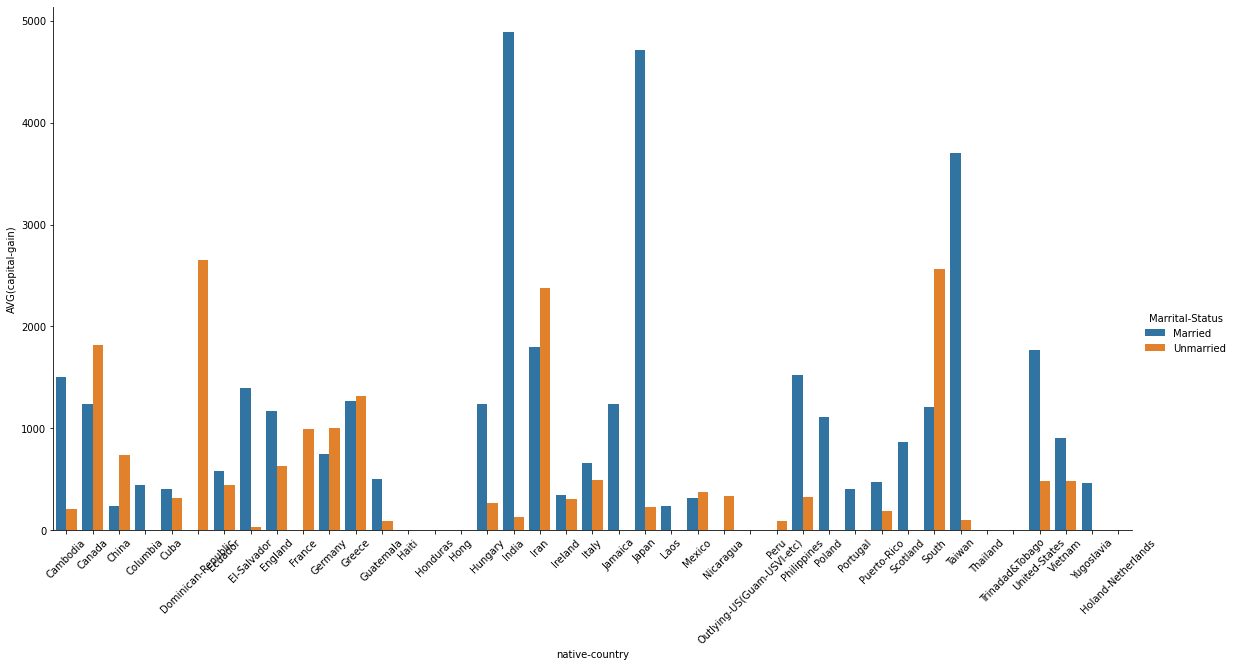

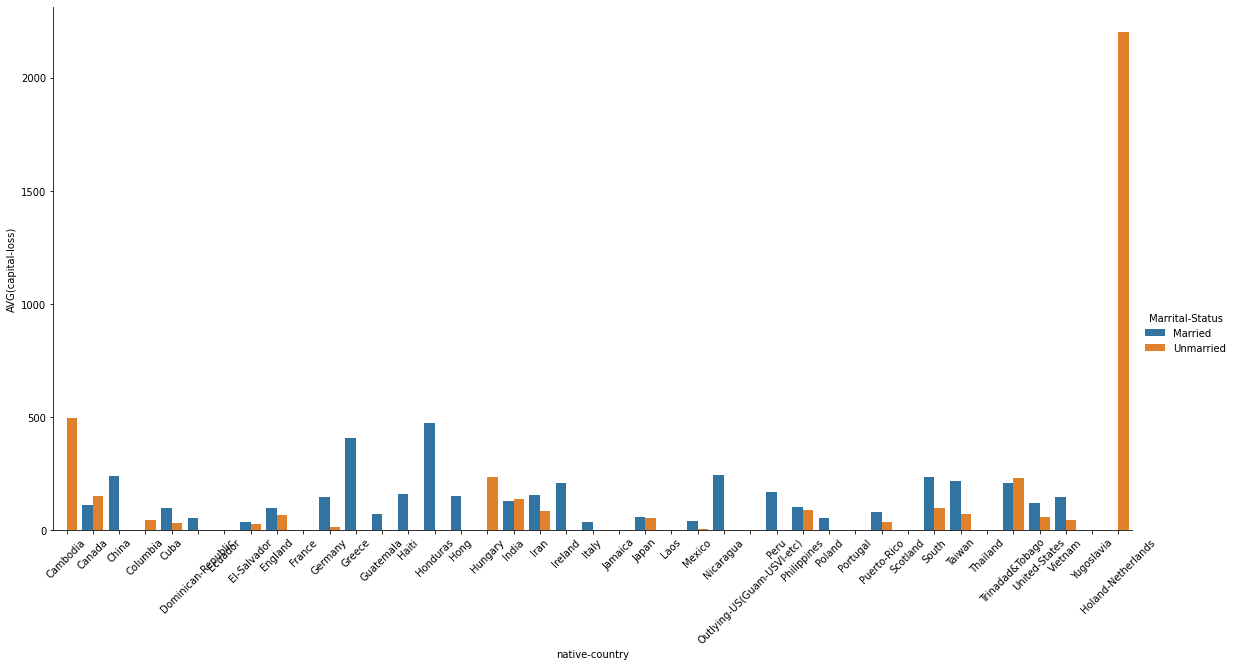

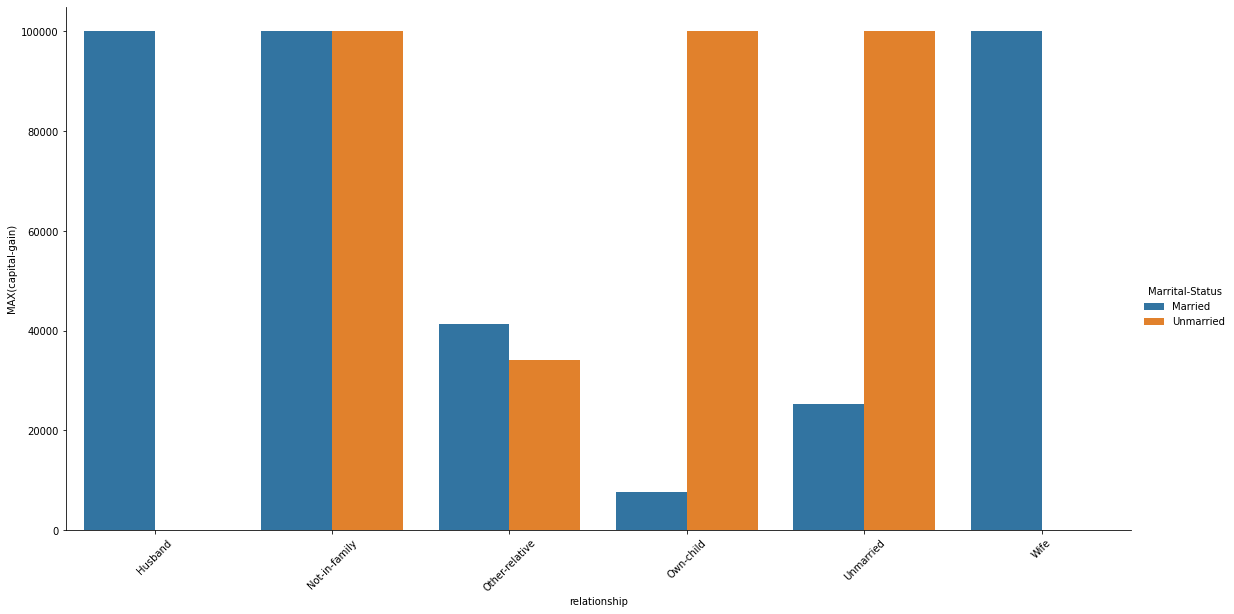

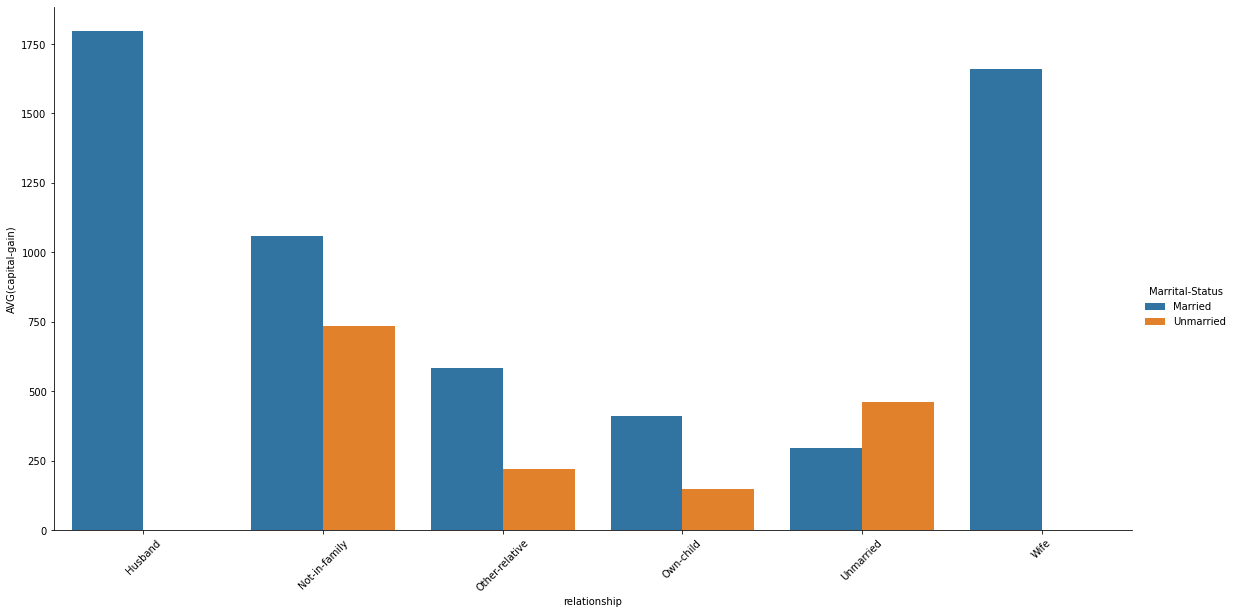

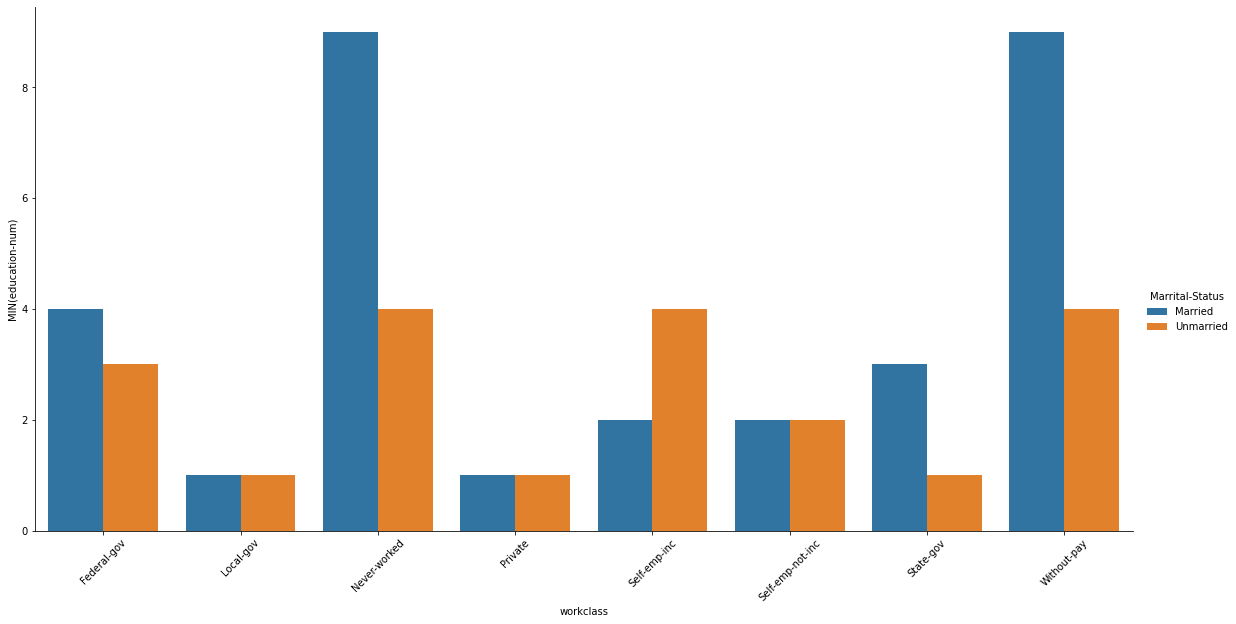

In [17]:
get_visualizations(top_k_utilities,'census')

# Extension 1 - Combining target and reference views

In [18]:
#generating queries for the combined thing
n = 36000
partitions = 5
bucket_len = ceil(n/partitions)


utility_details = collections.defaultdict(list)
utility_stats = collections.defaultdict(list)

for a in attributes:
    for f in functions:
        for m in measures:
            utility_details[(a,m,f)] = []
            utility_stats[(a,m,f)] = [0,0,0]
            
def pruning_combine_view_queries(utility_details,limit,offset):
    queries = []
    for a in attributes:
        flag = False
        query = 'SELECT "'+a+'"'
        query += ', CASE WHEN "marital-status" = \'Married\' THEN 1 ELSE 0 END AS MARRIED_STAT'
        query += ', CASE WHEN "marital-status" = \'Unmarried\' THEN 1 ELSE 0 END AS UNMARRIED_STAT'
        for f in functions:
            for m in measures:
                if (a,m,f) in utility_details:
                    flag = True
                    query += ', '+f+'("'+m+'")'
        query = query + ' from (Select * from public."Adult" LIMIT '+ str(limit)+' OFFSET '+  str(offset)+') temp where "' +a+ '" is not null group by "'+a+'", MARRIED_STAT, UNMARRIED_STAT order by "'+a+'" , MARRIED_STAT, UNMARRIED_STAT;'
   
        if flag==True:
            queries.append([a,query])
    return queries

#converting the combined query reult to two separate lists
def combined_agg_to_list(res):
    ref_vals = []
    tar_vals = []
    all_keys = set()
    const = Decimal(1e-10)
    vals = collections.defaultdict(list)
    ref_keys = dict()
    tar_keys = dict()
    
    for items in get_query_results(res):
        if items[1]==0:
            key = items[0]
            n = len(items) - 3
            all_keys.add(key)
            ref_keys[key] = list(items[3:])
            
        if items[2]==0:
            key = items[0]
            n = len(items) - 3
            all_keys.add(key)
            tar_keys[key] = list(items[3:])

    for key in all_keys:
        if key in ref_keys:
            ref_vals.append(ref_keys[key])
        else:
            ref_vals.append([const]*n)
        if key in tar_keys:
            tar_vals.append(tar_keys[key])
        else:
            tar_vals.append([const]*n)
    return ref_vals, tar_vals

#implementing shared-based and pruning-based optimization along with combining reference-target queries
def combine_views_optimization():
    for i in range(partitions):
        queries = pruning_combine_view_queries(utility_details,bucket_len,(i*bucket_len)+1)

        for a,query in queries:
            res = execute_query(query)

            ref_res,tar_res = combined_agg_to_list(res)
            if len(ref_res)<1:
                continue
            ref_res,tar_res = agg_normalize(a,ref_res), agg_normalize(a,tar_res)
            temp = get_pruning_agg_utility(a, ref_res, tar_res,utility_details)

            for t in temp:
                utility_details[t[1]].append(t[0])
                
            if i==0:
                continue
            get_stats(i+1)
            LCI = kth_LCI()
            keys = list(utility_stats.keys())
            for key in keys:
                if utility_stats[key][2]<LCI:
                    del utility_stats[key]
                    del utility_details[key]

    top_k_utilities = sorted(utility_stats, key = lambda x: utility_stats[x][0], reverse=True)[:k]
    print(top_k_utilities)
    return top_k_utilities

In [19]:
start4 = time.perf_counter()
top_k_utilities = combine_views_optimization()
end4 = time.perf_counter()
print('Time for Combined view optimization: '+ str(end4-start4))

[('native-country', 'capital-gain', 'avg'), ('native-country', 'capital-loss', 'avg'), ('native-country', 'capital-gain', 'max'), ('relationship', 'capital-gain', 'max'), ('relationship', 'capital-gain', 'avg')]
Time for Combined view optimization: 0.2867010999980266


('native-country', 'capital-gain', 'avg')
('native-country', 'capital-loss', 'avg')
('native-country', 'capital-gain', 'max')
('relationship', 'capital-gain', 'max')
('relationship', 'capital-gain', 'avg')


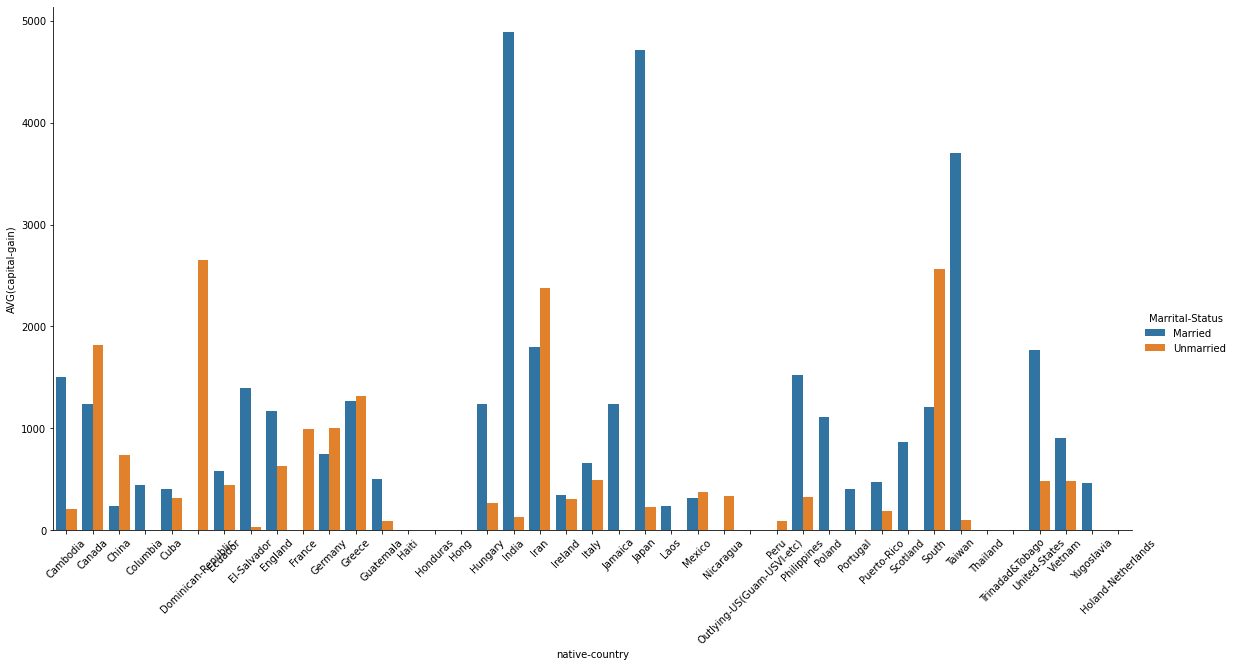

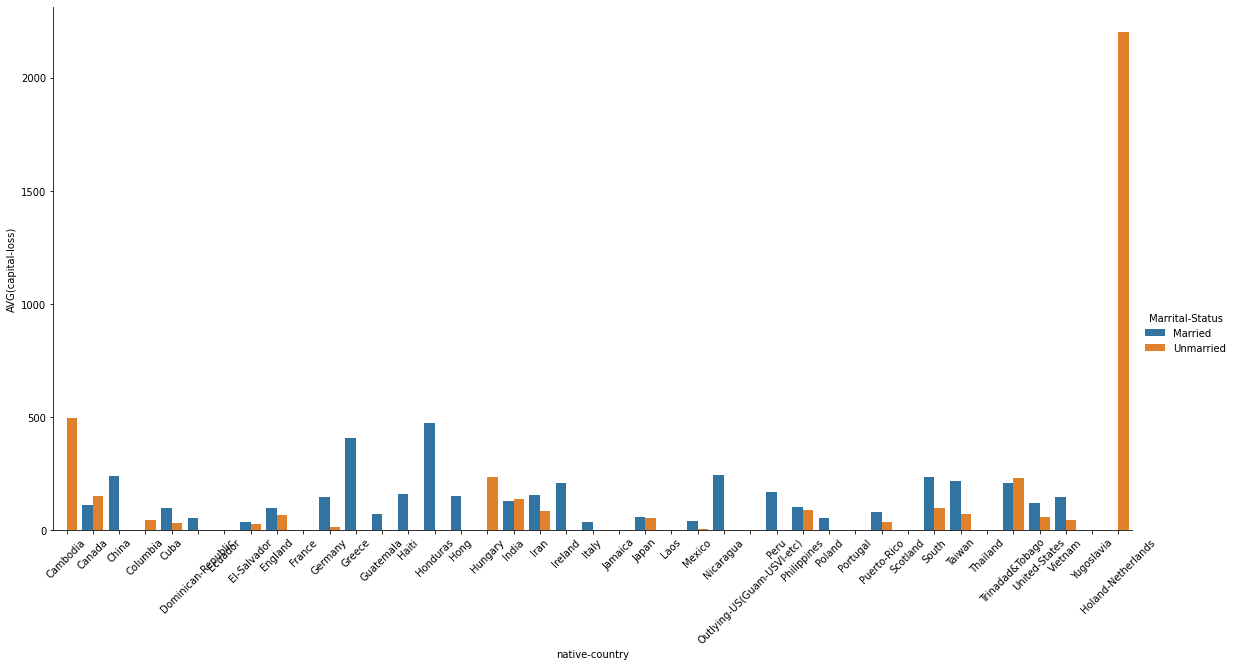

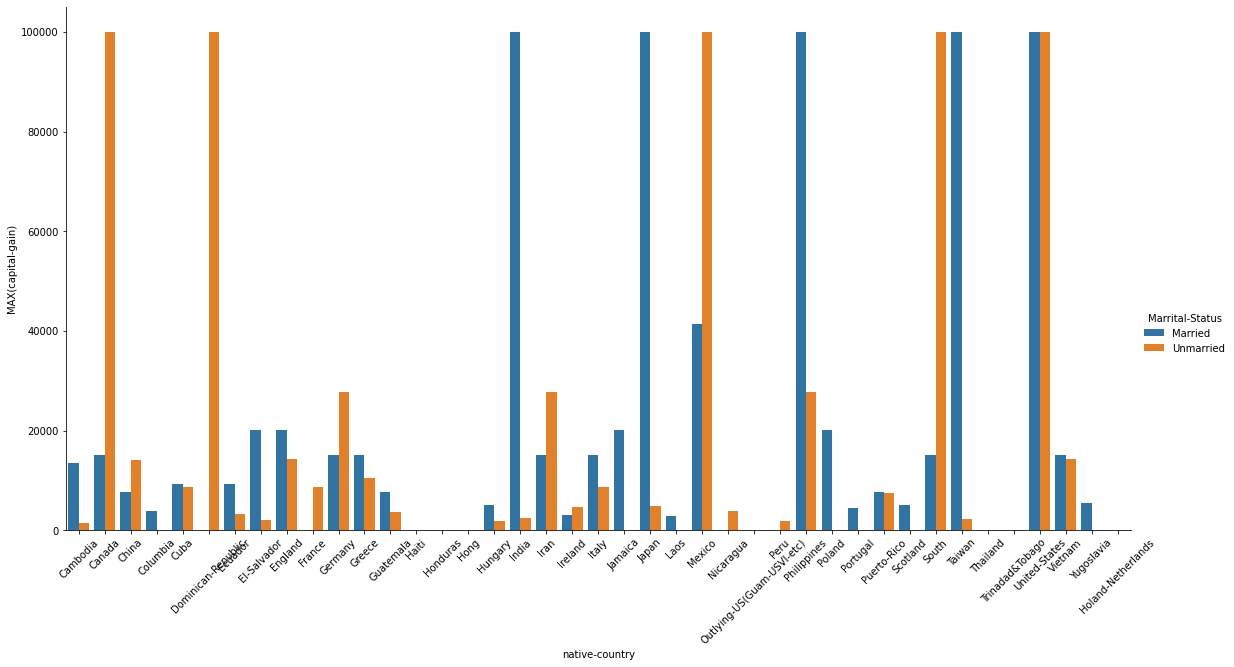

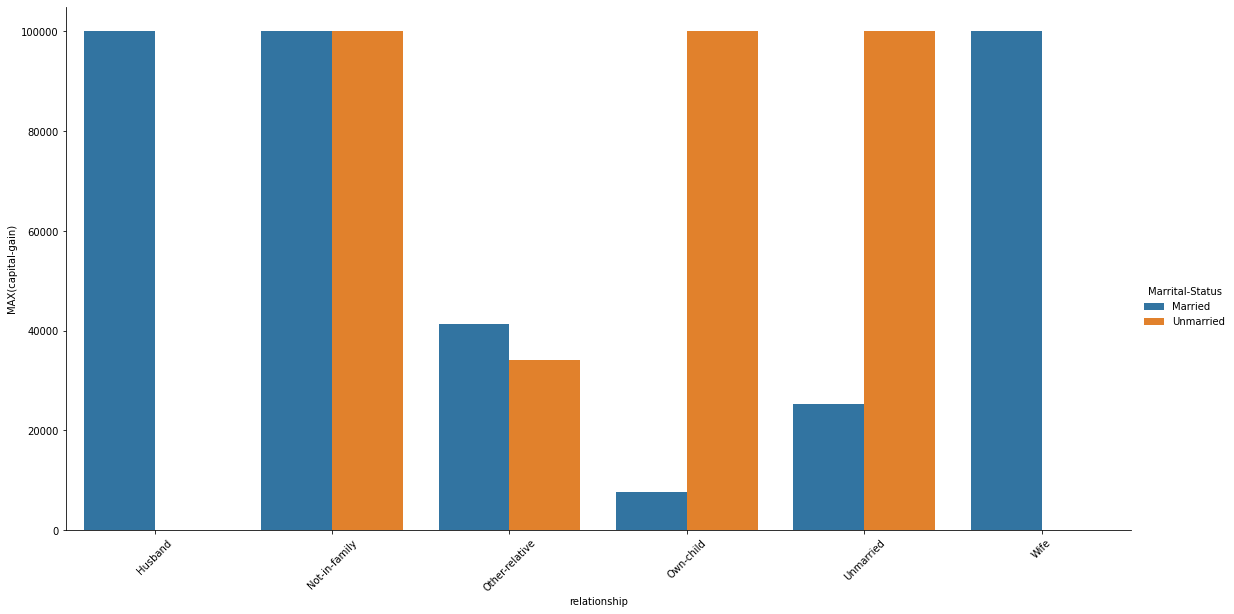

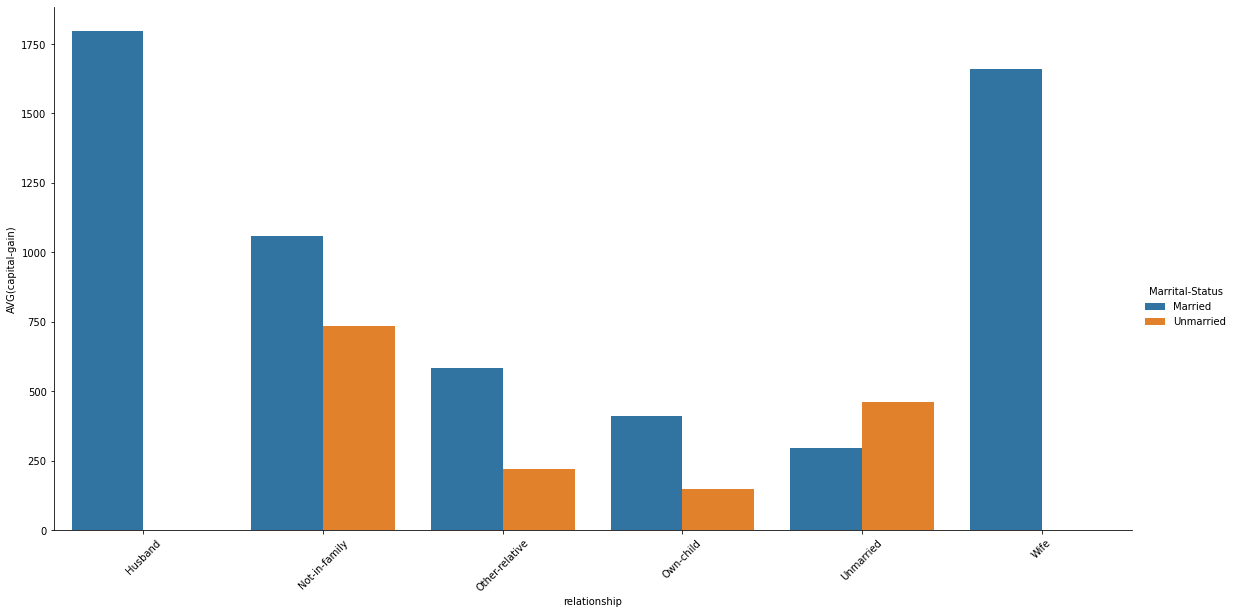

In [20]:
get_visualizations(top_k_utilities,'census')

# Extension 2 - Generating top k and bottom k views 

In [21]:
n = 36000
partitions = 5
bucket_len = ceil(n/partitions)


utility_details = collections.defaultdict(list)
utility_stats = collections.defaultdict(list)

for a in attributes:
    for f in functions:
        for m in measures:
            utility_details[(a,m,f)] = []
            utility_stats[(a,m,f)] = [0,0,0]
            
def ext_kth_LCI():
    max_kth_view = sorted(utility_stats, key = lambda x: utility_stats[x][0], reverse=True)[k-1]
    min_kth_view = sorted(utility_stats, key = lambda x: utility_stats[x][0])[k-1]
    return utility_stats[max_kth_view][1],utility_stats[min_kth_view][2]

def ext2_combine_views_optimization():
    for i in range(partitions):
        queries = pruning_combine_view_queries(utility_details,bucket_len,(i*bucket_len)+1)

        for a,query in queries:
            res = execute_query(query)

            ref_res,tar_res = combined_agg_to_list(res)
            if len(ref_res)<1:
                continue
            ref_res,tar_res = agg_normalize(a,ref_res), agg_normalize(a,tar_res)
            temp = get_pruning_agg_utility(a, ref_res, tar_res,utility_details)
            for t in temp:
                utility_details[t[1]].append(t[0])
            if i==0:
                continue
            get_stats(i+1)
            LCI, UCI = ext_kth_LCI()
            keys = list(utility_stats.keys())
            for key in keys:
                if (utility_stats[key][2]<LCI and utility_stats[key][1]>UCI) or utility_stats[key][0]==0.0:
                    del utility_stats[key]
                    del utility_details[key]

    top_k_utilities = sorted(utility_stats, key = lambda x: utility_stats[x][0], reverse=True)[:k]
    stored = sorted(utility_stats, key = lambda x: utility_stats[x][0])[:k]
    top_k_utilities += stored
    
    return top_k_utilities

In [22]:
k = 3
top_k_utilities = ext2_combine_views_optimization()

('native-country', 'capital-loss', 'avg')
('relationship', 'capital-loss', 'max')
('relationship', 'capital-loss', 'avg')
('sex', 'education-num', 'avg')
('sex', 'age', 'min')
('income', 'age', 'max')


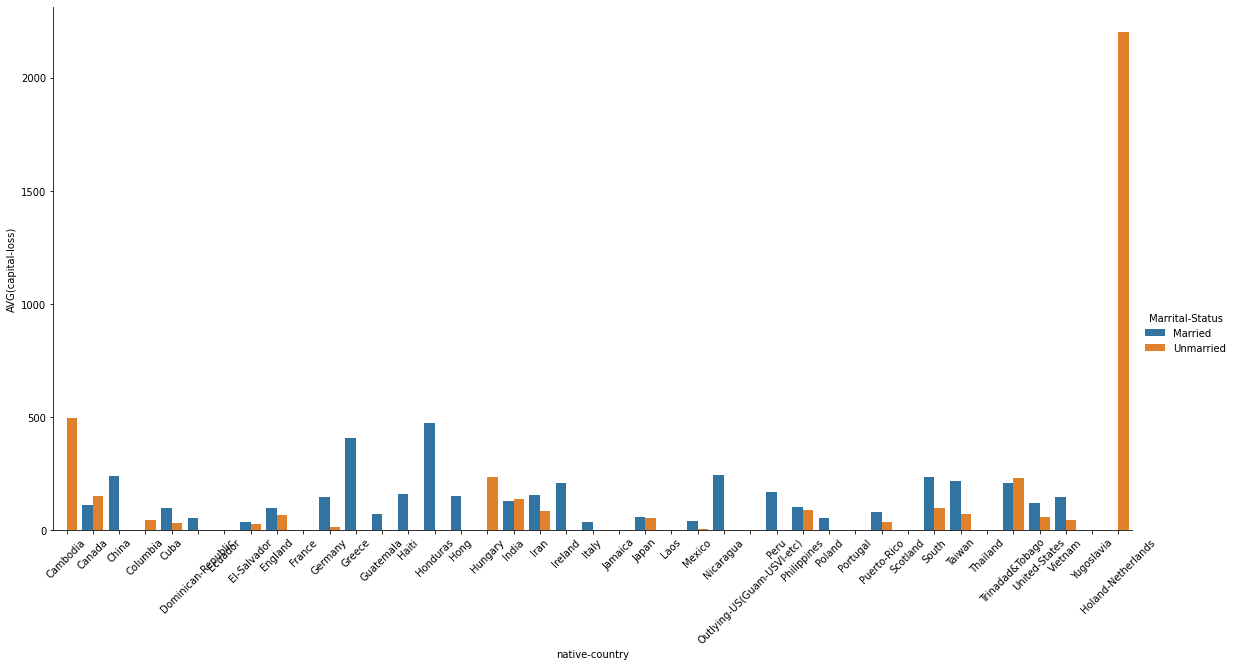

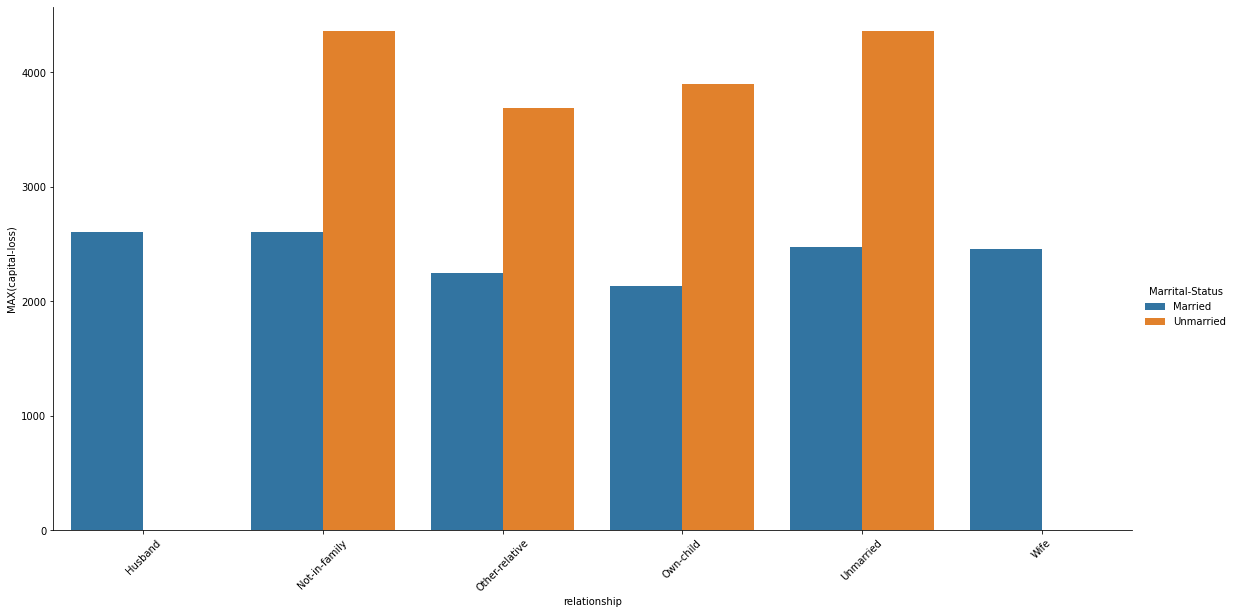

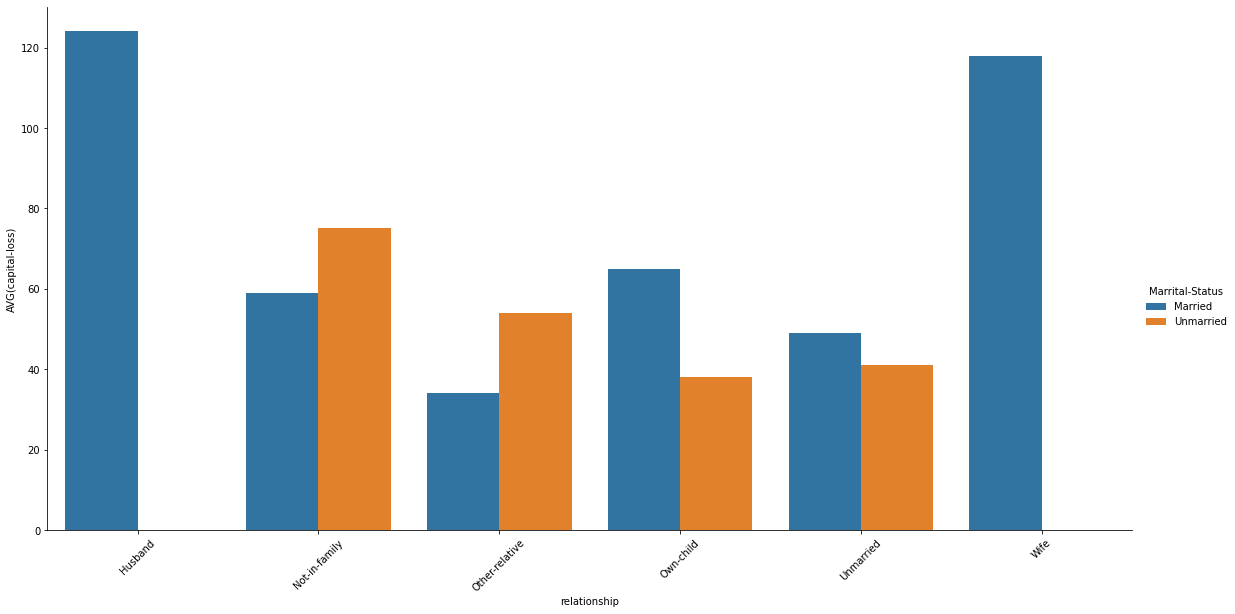

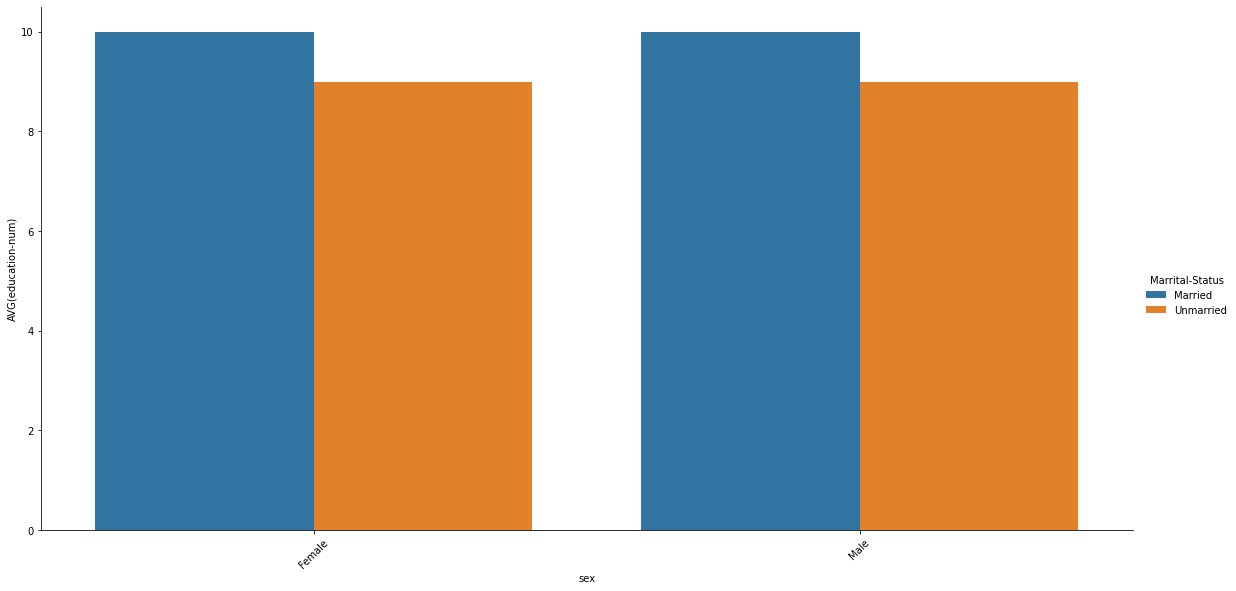

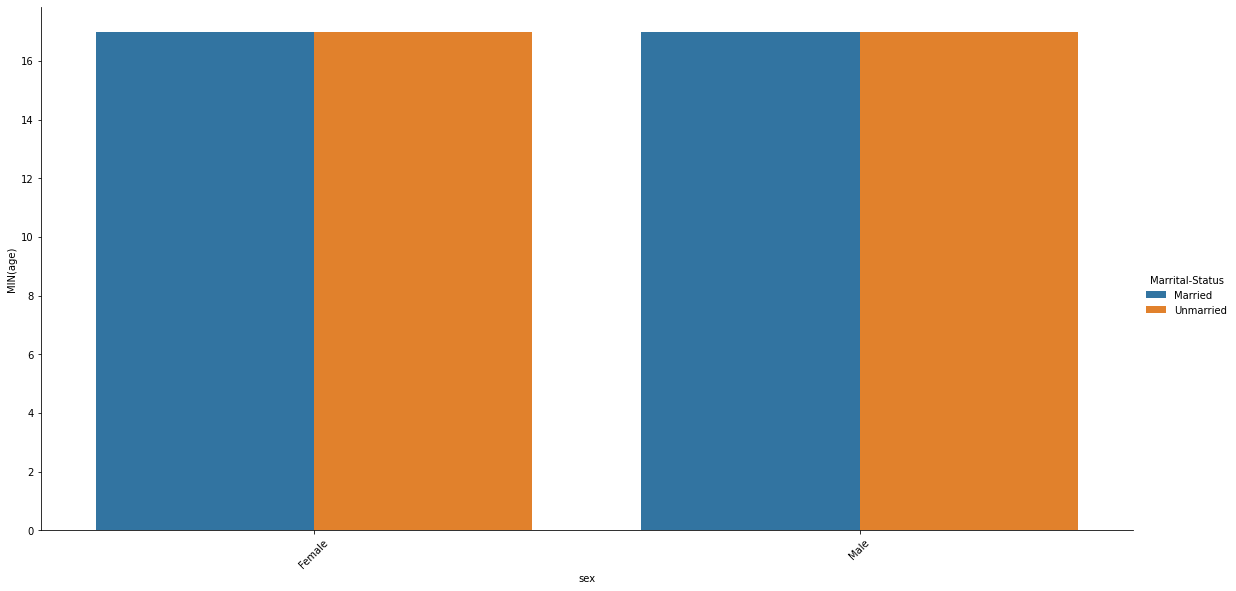

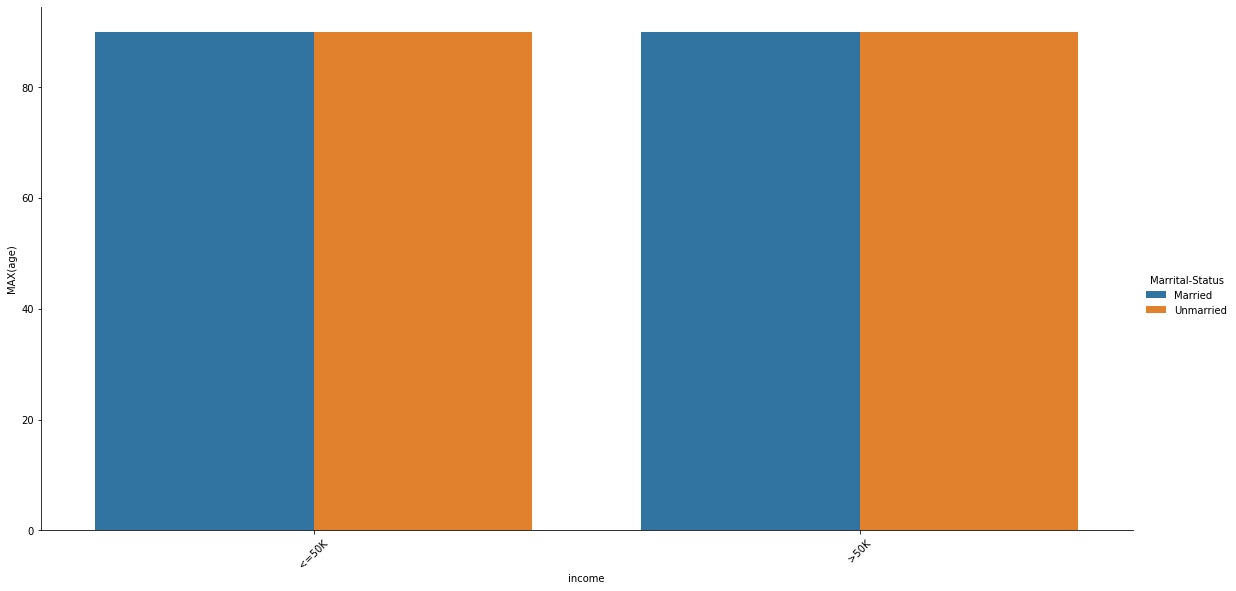

In [23]:
get_visualizations(top_k_utilities, 'census')

# Extension 3 - Implementing on DBLP dataset

In [24]:
DATA = "dblp"
functions = ['count']
attributes = ['paper_id','author_id','type']
measures = ['paper_id','author_id','type']

n = 2828437
partitions = 5
bucket_len = ceil(n/partitions)
k = 5

utility_details = collections.defaultdict(list)
utility_stats = collections.defaultdict(list)

for a in attributes:
    for f in functions:
        for m in measures:
            if a==m:
                continue
            utility_details[(a,m,f)] = []
            utility_stats[(a,m,f)] = [0,0,0]


In [25]:
start1 = time.perf_counter()
top_k_utilities = exhaustive_search(DATA)
end1 = time.perf_counter()

print("Exhaustive Search :")
print("TOP K Views: utlity_values + (a,f,m) :")
print(top_k_utilities)

Exhaustive Search :
TOP K Views: utlity_values + (a,f,m) :
[(28.176913582978937, ('count', 'paper_id', 'type')), (28.176913582978937, ('count', 'paper_id', 'author_id')), (28.176913582978937, ('count', 'paper_id', 'paper_id')), (14.588062167246408, ('count', 'author_id', 'type')), (14.588062167246408, ('count', 'author_id', 'author_id'))]


In [26]:
start2 = time.perf_counter()
top_k_utilities = shared_based_optimization(DATA)
end2 = time.perf_counter()

print("SHARED BASED OPTIMIZATION :")
print("TOP K Views: utlity_values + (a,f,m) :")
print(top_k_utilities)

SHARED BASED OPTIMIZATION :
TOP K Views: utlity_values + (a,f,m) :
[(28.176913582978937, ('paper_id', 'count', 'type')), (28.176913582978937, ('paper_id', 'count', 'author_id')), (14.588062167246408, ('author_id', 'count', 'type')), (14.588062167246408, ('author_id', 'count', 'paper_id')), (0.003777370507027459, ('type', 'count', 'author_id'))]


In [27]:
start3 = time.perf_counter()
top_k_utilities = pruning_based_optimization(DATA)
end3 = time.perf_counter()

print("PRUNING BASED OPTIMIZATION :")
print("TOP K Views: utlity_values + (a,m,f) :")
print(top_k_utilities)

PRUNING BASED OPTIMIZATION :
TOP K Views: utlity_values + (a,m,f) :
[('paper_id', 'author_id', 'count'), ('paper_id', 'type', 'count'), ('author_id', 'paper_id', 'count'), ('author_id', 'type', 'count'), ('type', 'paper_id', 'count')]


In [28]:
print('Time for exhaustive search: ' + str(end1-start1))
print('Time for shared-based optimization: '+ str(end2-start2))
print('Time for Pruning-based optimization: '+ str(end3-start3))

Time for exhaustive search: 37.31493390000105
Time for shared-based optimization: 25.17552920000162
Time for Pruning-based optimization: 53.0189509999982


('paper_id', 'author_id', 'count')
('paper_id', 'type', 'count')
('author_id', 'paper_id', 'count')
('author_id', 'type', 'count')
('type', 'paper_id', 'count')


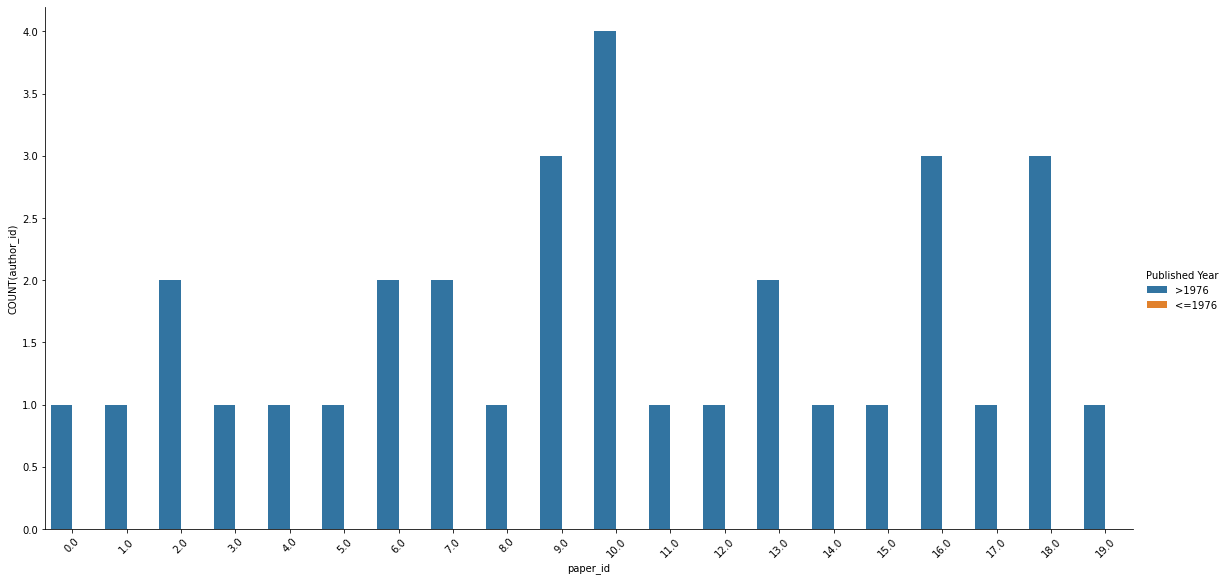

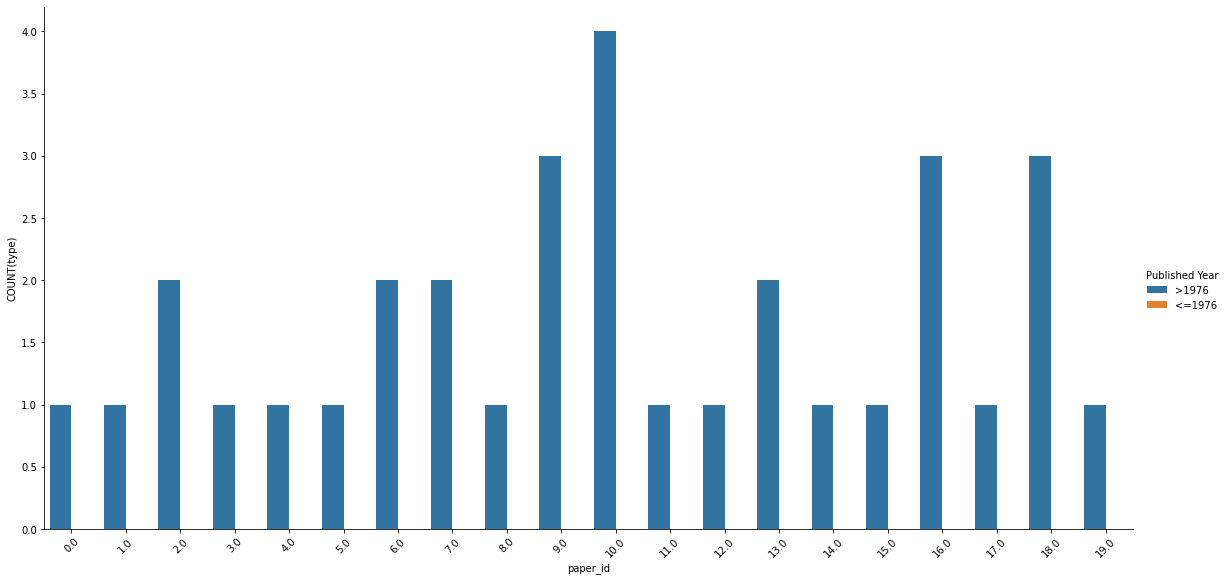

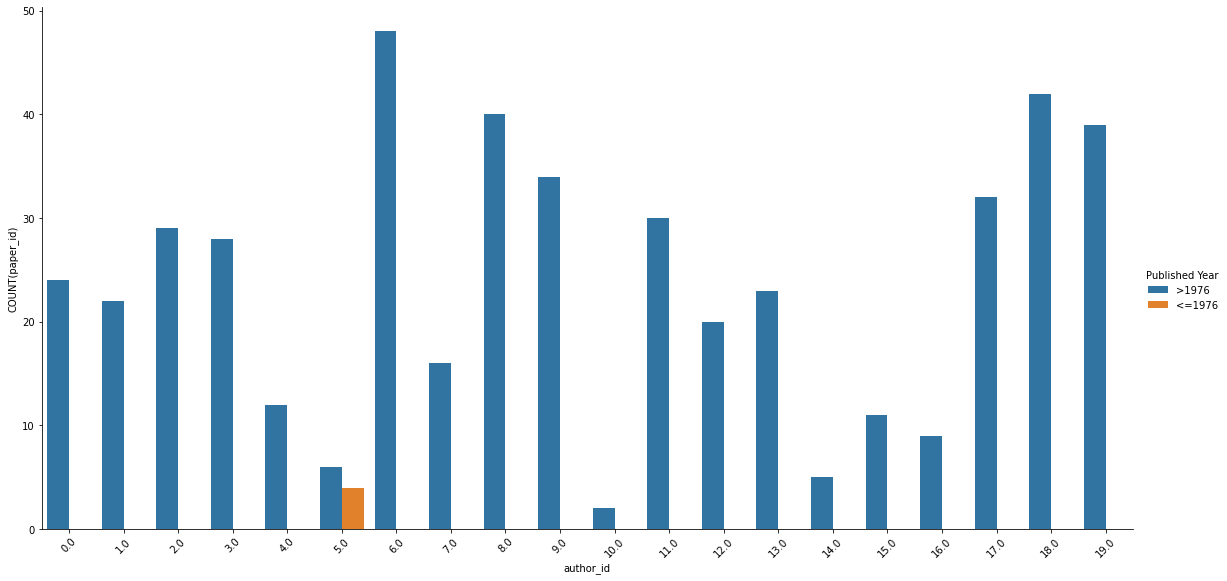

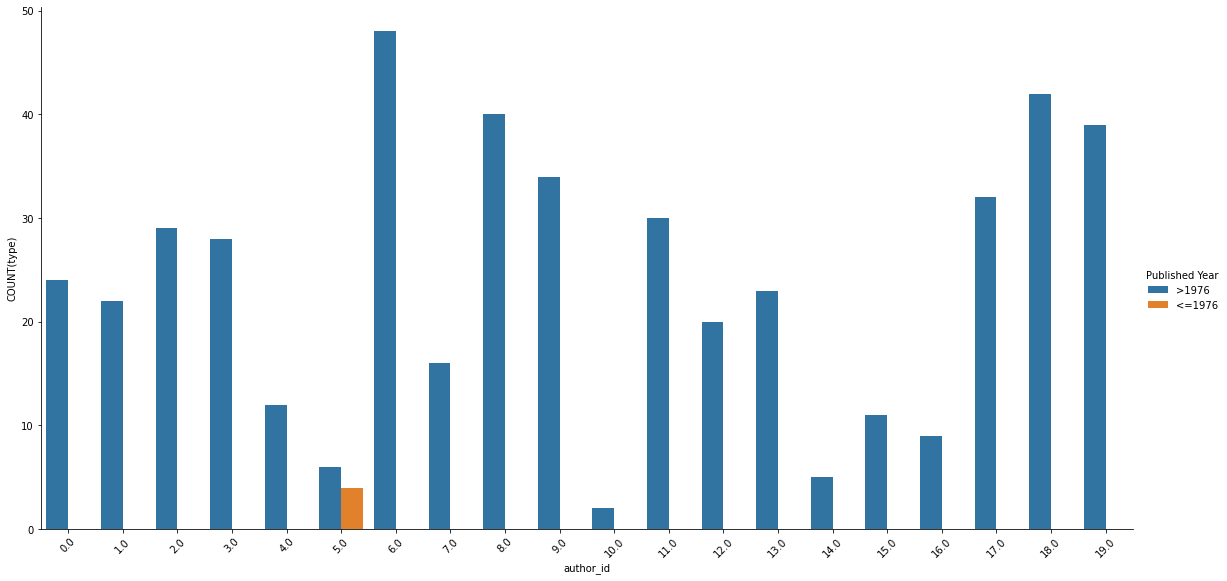

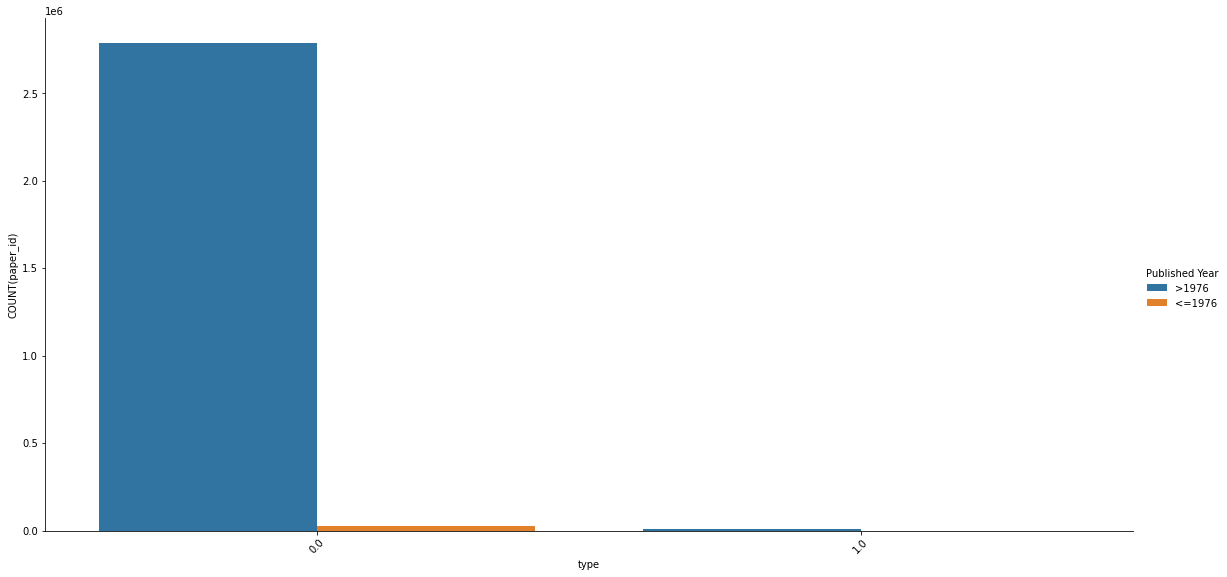

In [29]:
get_visualizations(top_k_utilities,'dblp')